In [1]:
import torch
from tqdm.autonotebook import tqdm
import pandas as pd
from pathlib import Path
import os
import random
from datetime import date
import numpy as np

from utils import SliceDataset

import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath('/root/data_filtering_mri'))  # Adjust this to the actual path

# from src.data_filt_setups.HeuristicFiltering.HighFrequencyFiltering import HighFrequencyFiltering
from src.data_filt_setups.data_filt_setups import list_data_filtering_setups_str, get_data_filtering_setup
# Import BART for sensitivity maps estimation:
import sys
sys.path.insert(0,'/root/bart-0.6.00/python/')
os.environ['TOOLBOX_PATH'] = "/root/bart-0.6.00/"
import bart

def sensmaps_estimation(masked_kspace):   
    sens_maps = bart.bart(1, f'ecalib -d0 -m1', np.array([masked_kspace.moveaxis(0,2)]))
    return torch.from_numpy(np.moveaxis(sens_maps[0],2,0))

def plot_kspace_channels(kspace_data, vmax=None):
    # 获取通道数
    num_channels = kspace_data.shape[0]
    
    # 确定列数（每行6-8个图）
    num_cols = min(8, num_channels)
    
    # 计算所需行数
    num_rows = int(np.ceil(num_channels / num_cols))
    
    # 如果没有提供vmax，则计算全局最大值
    if vmax is None:
        # 对所有通道计算log magnitude
        log_mags = [np.log(np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(ch)))) + 1) for ch in kspace_data]
        vmax = np.percentile(np.concatenate(log_mags), 99)
    
    # 创建紧凑布局的图形
    plt.figure(figsize=(4*num_cols, 4*num_rows*kspace_data.shape[1]/kspace_data.shape[2]))
    plt.tight_layout()
    
    # 对每个通道进行处理和可视化
    for i in range(num_channels):
        # 对k空间数据进行傅里叶变换
        image = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace_data[i])))
        
        # 取绝对值并对数标度
        image_mag = np.log(np.abs(image) + 1)
        
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(image_mag, cmap='gray', vmin=0, vmax=vmax)
        plt.title(f'Channel {i}')
        plt.axis('off')
    
    plt.show()
    plt.tight_layout()
def combine_image_smaps(image, smaps):
    # Calculate the complex conjugate of sensitivity maps
    smaps_conj = torch.conj(smaps)
    
    # Weighted sum over coils: image * conjugate(smaps) / sum(|smaps|^2 over coils)
    numerator = torch.sum(smaps_conj * image, dim=0)
    denominator = torch.sum(smaps_conj * smaps, dim=0)
    
    # To avoid division by zero, add a small epsilon to the denominator
    combined = numerator / (denominator + 1e-8)
    return combined
# Function to normalize an image (for complex values, we take the absolute value)
def normalize_image(image):
    # Take the absolute value for complex numbers
    image_abs = torch.abs(image)
    
    # Normalize the absolute image values to range [0, 1]
    image_min = torch.min(image_abs)
    image_max = torch.max(image_abs)
    
    return (image_abs - image_min) / (image_max - image_min)

# Function to remove specific coils from image and sensitivity maps
def remove_coils(image, smaps, discard_coils):
    # Create a mask that keeps the coils not in discard_coils
    total_coils = image.shape[0]  # assuming coil dimension is 0
    mask = torch.ones(total_coils, dtype=torch.bool)
    mask[discard_coils] = False  # Set discard_coils to False
    
    # Use the mask to select the coils that are not discarded
    image_modified = image[mask]
    smaps_modified = smaps[mask]
    
    return image_modified, smaps_modified

# Function to display the images
def plot_images(original, modified):
    plt.figure(figsize=(9, 4.5*original.shape[0]/original.shape[1]))
    
    # Display the original combined image
    plt.subplot(1, 2, 1)
    plt.title("Original Combined Image")
    plt.imshow(original.cpu().numpy(), cmap='gray')
    plt.axis('off')
    # Display the modified image (after removing coils)
    plt.subplot(1, 2, 2)
    plt.title("Modified Combined Image (Coils Removed)")
    plt.imshow(modified.cpu().numpy(), cmap='gray')
    plt.axis('off')
    
    plt.show()
    plt.tight_layout()

# Main function for the process
def process_mri_combination(idx, discard_coils,filtering_setup):
    print(f"The file name is {filtering_setup.dataset[idx][3]} with slice number {filtering_setup.dataset[idx][4]}")
    # Load the k-space data from filtering_setup
    kspace = filtering_setup.dataset[idx][0]  # Assuming k-space data is provided in numpy array
    
    # Apply IFFT to convert k-space to image domain
    image = torch.tensor(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace))))
    # Estimate sensitivity maps
    smaps = sensmaps_estimation(torch.tensor(kspace))  # You might need to use kspace for estimating smaps
    print(image.shape)
    print(smaps.shape)
    # Combine image and sensitivity maps to get the original combined image
    combined_image = combine_image_smaps(image, smaps)
    
    # Remove the specified coils from image and smaps
    image_modified, smaps_modified = remove_coils(image, smaps, discard_coils)
    
    # Combine the modified image and smaps after coil removal
    combined_image_modified = combine_image_smaps(image_modified, smaps_modified)
    
    # Normalize the images
    normalized_combined_image = normalize_image(combined_image)
    normalized_combined_image_modified = normalize_image(combined_image_modified)
    
    # Plot the original and modified images
    plot_images(normalized_combined_image, normalized_combined_image_modified)


print("Available Filtering Setups:")
print(list_data_filtering_setups_str())

/tmp/ipykernel_752953/1584255472.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Available Filtering Setups:
EnergyFiltering
HighFrequencyFiltering
LaplacianBlurDetection
SobelFlatRegionDetection
EdgeSparsityDetection
RandomPickDetection
CoilWiseScoreFiltering


In [2]:
from src.data_filt_setups.data_filt_setups import list_data_filtering_setups_str, get_data_filtering_setup
# dataset_path = '/root/data_filtering_mri/datasets/train/data_pool_random_volume_subset.json'
# dataset_path = '/root/data_filtering_mri/datasets/train/data_pool_random_volume_subset_EnergyFiltering_threshold_0.1.json'
dataset_path = '/root/data_filtering_mri/datasets/train/data_pool_random_volume_subset.json'
# Change the name of the method:
filtering_setup = get_data_filtering_setup('CoilWiseScoreFiltering', file_path=dataset_path, is_debug=True)
filtered_samples,metric_record = filtering_setup.filter()


Calculating scores in debug mode:   0%|          | 0/101710 [00:00<?, ?it/s]

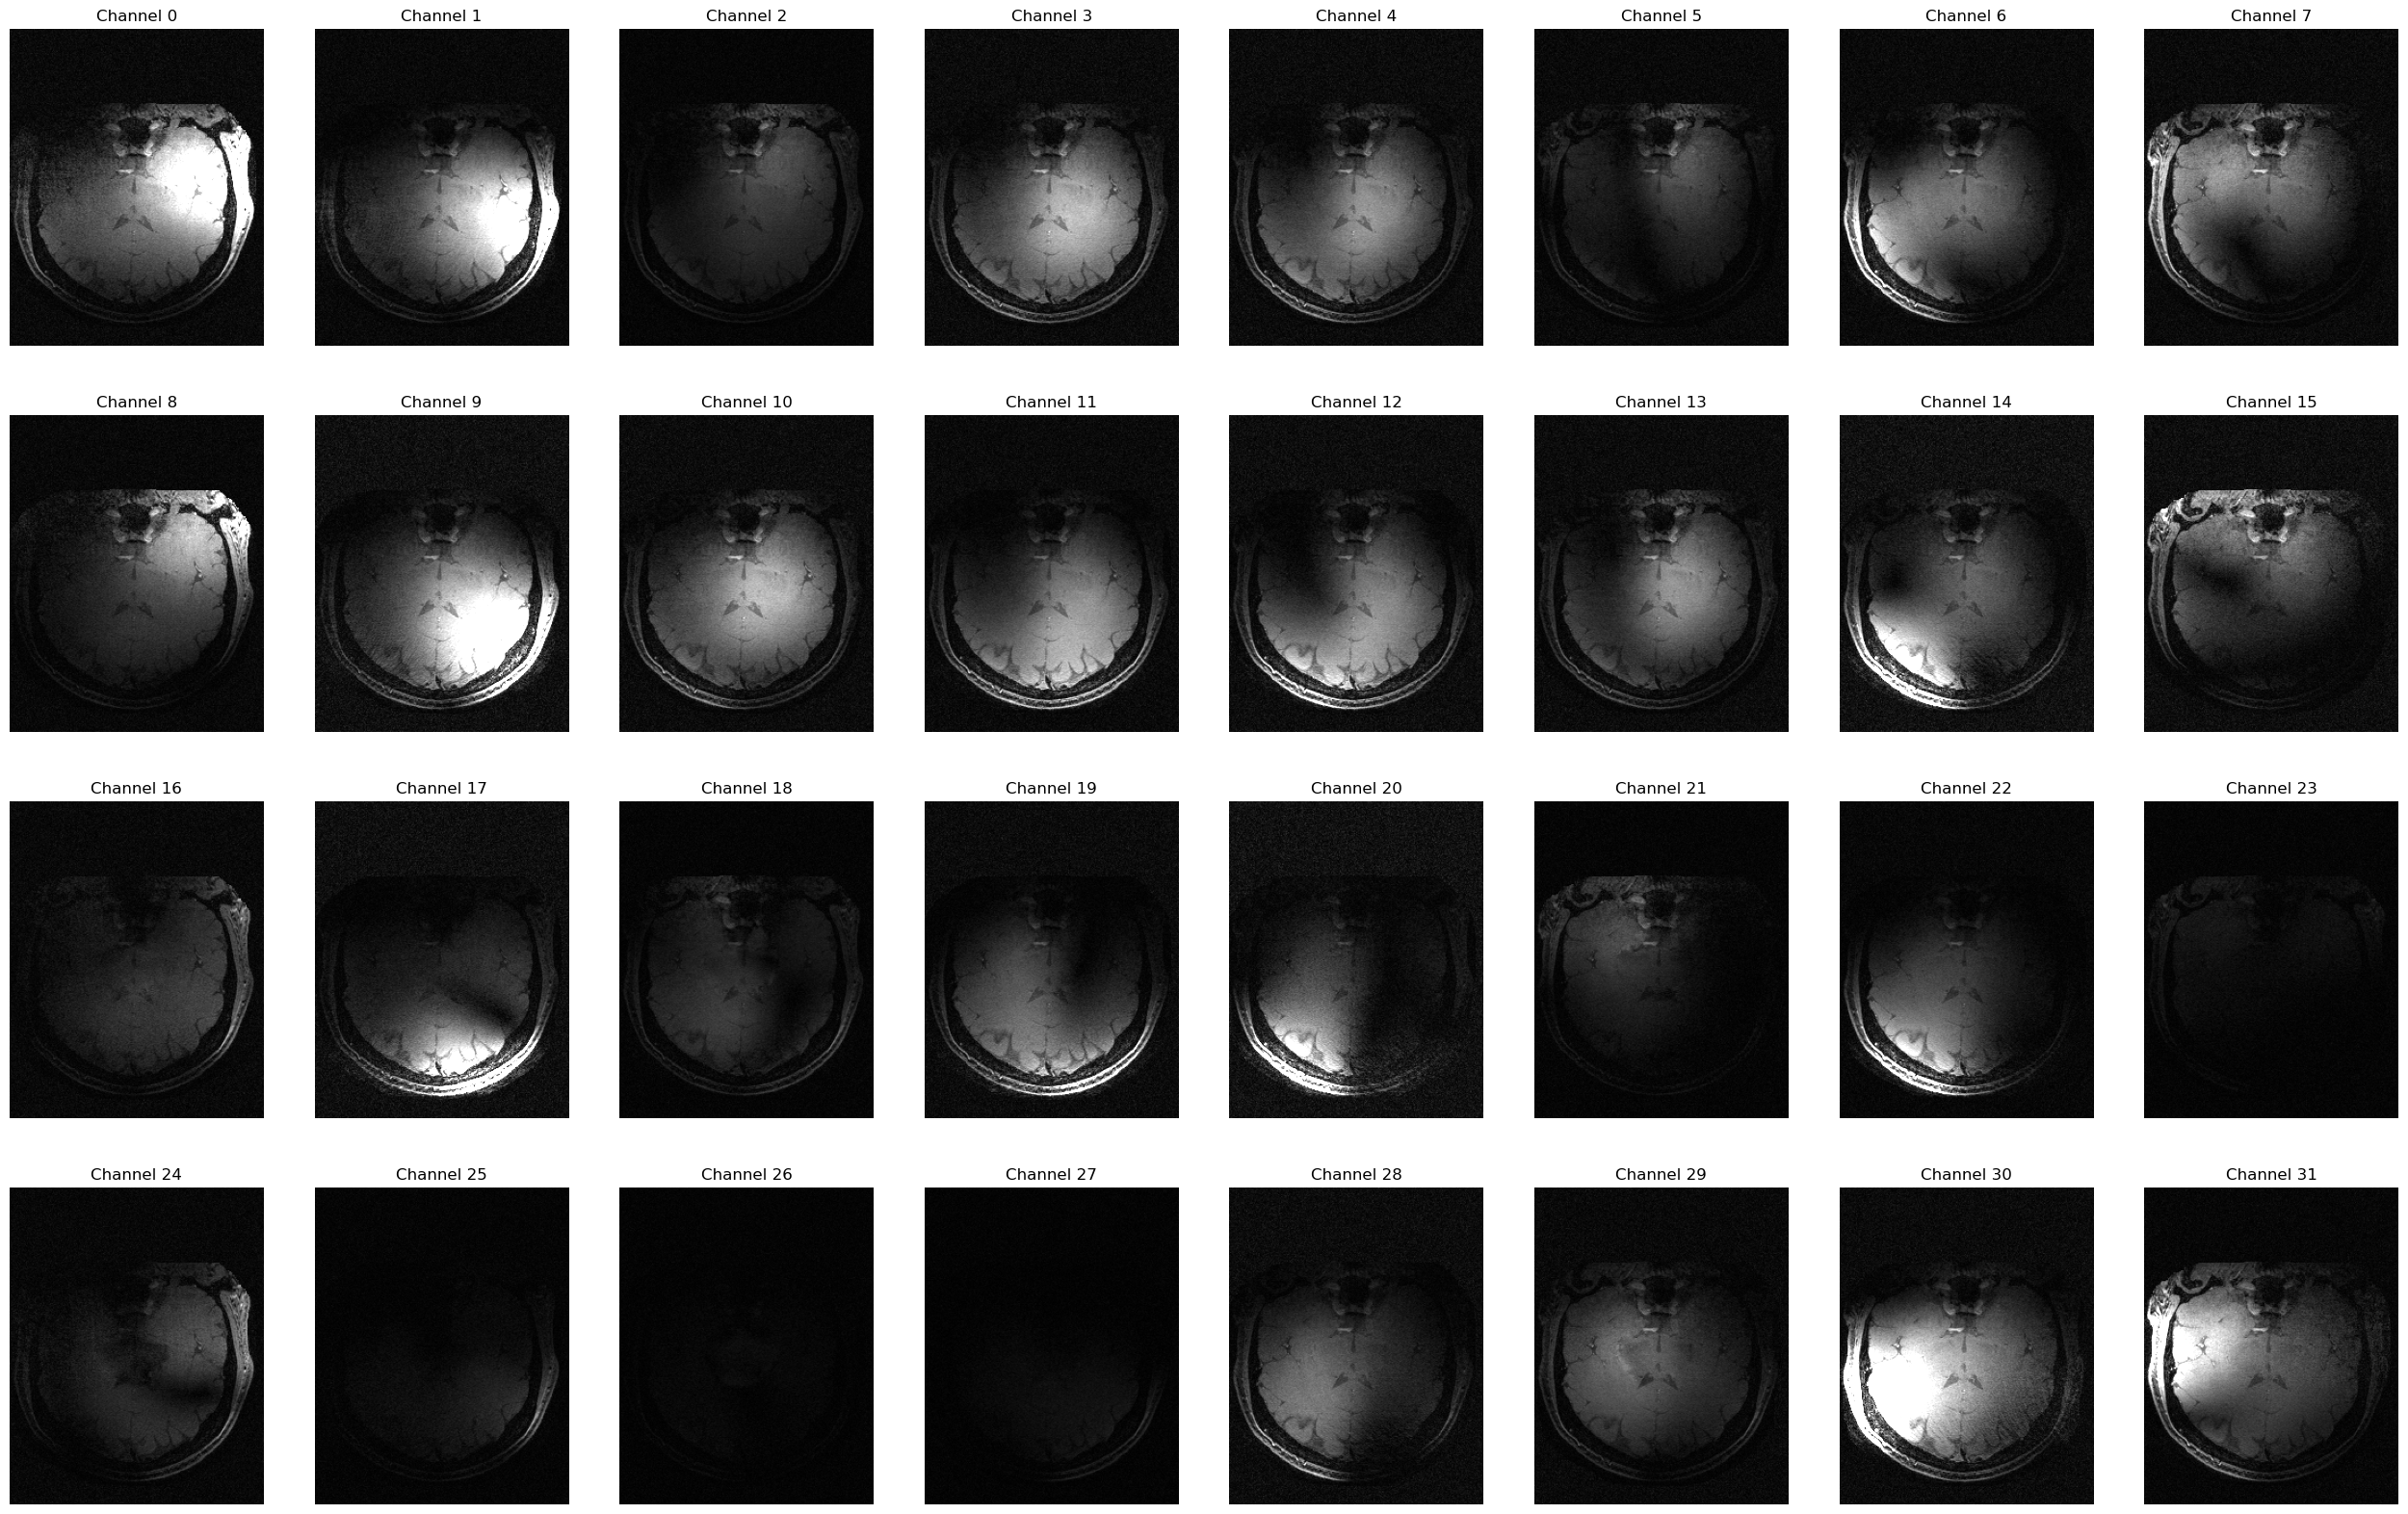

<Figure size 640x480 with 0 Axes>

In [27]:
# Randomly select Nc samples from each group (ensure we don't exceed available samples)
high_metric_indices = [i for i, metric in enumerate(metric_record) if metric < 0.2]
# filtering_setup.dataset[random.sample(high_metric_indices, 1)[0]][0].shape
sample_idx = random.sample(high_metric_indices, 1)[0]
# sample_idx_list = [1743]
# sample_name_list = ['mp2rageme_013_inv2_te1_cor.h5']
plot_kspace_channels(filtering_setup.dataset[sample_idx][0], vmax=None)

The file name is mp2rageme_013_inv2_te1_cor.h5 with slice number 208
Done.
torch.Size([32, 292, 234])
torch.Size([32, 292, 234])


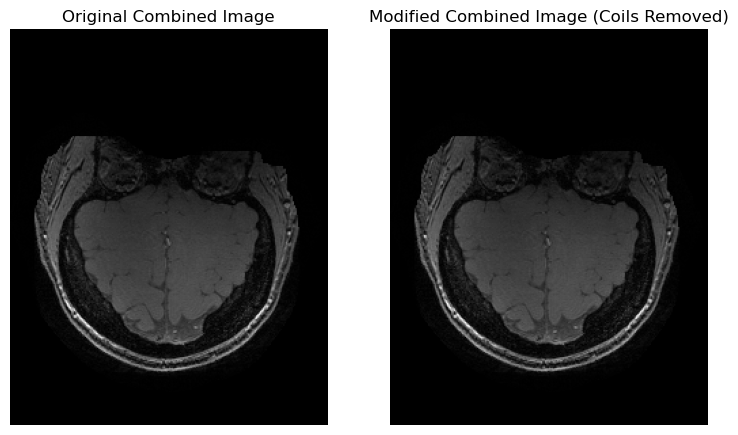

<Figure size 640x480 with 0 Axes>

In [22]:
discard_coils = [0]  # Example of non-consecutive coils to discard
process_mri_combination(idx=sample_idx, discard_coils=discard_coils,filtering_setup=filtering_setup)

Done.
torch.Size([8, 512, 160])
torch.Size([8, 512, 160])


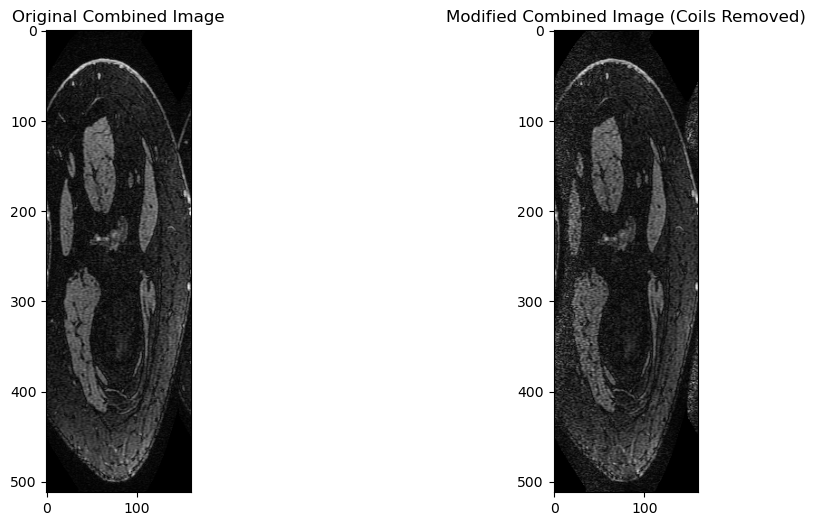

In [18]:
smaps.shape

(8, 512, 160)

In [34]:
filtering_setup.dataset[sample_idx][3]

'mp2rageme_013_inv2_te1_cor.h5'

(-0.5, 159.5, 511.5, -0.5)

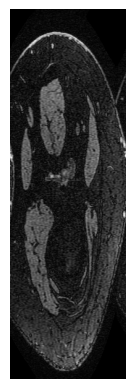

In [31]:
plt.imshow(abs(filtering_setup.dataset[sample_idx][1]),'gray')
plt.axis('off')

Use a part of the sensitivity maps to get the updated 

In [124]:
filtering_setup.dataset[random.sample(high_metric_indices, 1)[0]][2]['max']

{'max': 0.00012205023,
 'max_mvue': 0.00012205023,
 'padding_left': 0,
 'padding_right': 234,
 'encoding_size': (292, 234, 1),
 'recon_size': (292, 234, 1),
 'target_shape': (292, 234),
 'kspace_shape': (32, 292, 234)}

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_kspace_channels(kspace_data, vmax=None):
    # 获取通道数
    num_channels = kspace_data.shape[0]
    
    # 确定列数（每行6-8个图）
    num_cols = min(8, num_channels)
    
    # 计算所需行数
    num_rows = int(np.ceil(num_channels / num_cols))
    
    # 如果没有提供vmax，则计算全局最大值
    if vmax is None:
        # 对所有通道计算log magnitude
        log_mags = [np.log(np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(ch)))) + 1) for ch in kspace_data]
        vmax = np.percentile(np.concatenate(log_mags), 99)
    
    # 创建紧凑布局的图形
    plt.figure(figsize=(4*num_cols, 4*num_rows))
    plt.tight_layout(pad=3.0)
    
    # 对每个通道进行处理和可视化
    for i in range(num_channels):
        # 对k空间数据进行傅里叶变换
        image = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace_data[i])))
        
        # 取绝对值并对数标度
        image_mag = np.log(np.abs(image) + 1)
        
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(image_mag, cmap='gray', vmin=0, vmax=vmax)
        plt.title(f'Channel {i+1}')
        plt.axis('off')
    
    plt.show()

# 示例使用
# 假设你的k空间数据是形状为 (16, 320, 192)
# 替换为你的实际k空间数据
kspace_data = np.random.complex128((16, 320, 192))
plot_kspace_channels(kspace_data)

AttributeError: module 'numpy.random' has no attribute 'complex128'